In this notebook, we explore the effect of different bet sizing methods.

More specifically, we'll look into :
- fixed size
- cumulative size (always 100% exposed)
- kelly criterion
- martingale and anti-martingale
- VaR (value at risk)

Let's get to it.

In [272]:
import pandas as pd
import yfinance as yf
import talib
import vectorbt as vbt
import numpy as np
import matplotlib.pyplot as plt
import empyrical as ep

In [61]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load data
data = yf.download('spy')['Adj Close']

[*********************100%%**********************]  1 of 1 completed


### The Strategy

We will use a well-known, long only strategy named "RSI PowerZones", derived from the book "Buy the Fear, Sell the Greed" from Larry Connors. The strategy trades the S&P 500 using just the SMA200 and RSI4.

In [262]:
# Define parameters (derived from the book)
sma_window = 200
rsi_window = 4
rsi_lower1 = 30
rsi_lower2 = 25
rsi_upper = 55

# Computing indicators
sma200 = data.rolling(sma_window).mean().shift(1)
if len(data.shape) > 1:
    rsi4 = {} 
    for c in data.columns:
        rsi4[c] = talib.RSI(data[c], rsi_window)
    rsi4 = pd.DataFrame(rsi4)
else:
    rsi4 = talib.RSI(data, rsi_window)
    
# Generating signals
entries = (data > sma200) & (rsi4.vbt.crossed_below(rsi_lower1) | rsi4.vbt.crossed_below(rsi_lower2))
exits = rsi4.vbt.crossed_above(rsi_upper)

# Getting all trades occured
pf = vbt.Portfolio.from_signals(data, entries, exits)
trades = pf.trades.records_readable[['Entry Timestamp', 'Avg Entry Price', 'Exit Timestamp', 'Avg Exit Price', 'Return']]
trades.columns = ['Entry_Timestamp', 'Entry_Price', 'Exit_Timestamp', 'Exit_Price', 'Return']

In [263]:
trades.head()

Entry_Timestamp  Entry_Price Exit_Timestamp  Exit_Price    Return
0      1993-11-22    26.414629     1993-11-24   26.665701  0.009505
1      1994-01-03    26.848238     1994-01-07   27.173220  0.012104
2      1994-02-04    27.137119     1994-02-15   27.426008  0.010646
3      1994-02-18    27.082928     1994-02-22   27.353767  0.010000
4      1994-02-24    26.920439     1994-03-07   27.119072  0.007379

### Getting the different equities, per bet size method

In [264]:
# Fixed Size

pnl = trades.Return * 100
fixed_size_equity = trades.Return.mul(100).cumsum().add(100)

In [265]:
# Cumulative Size (always 100% exposed)

cum_size_equity = trades.Return.add(1).cumprod().mul(100)

In [266]:
# Kelly Criterion

df = trades.copy()
df['Kelly'] = 0

for i in range(1, len(df)):
    
    # Calculate rolling win probability, average win return, and loss probability
    past_trades = df.iloc[:i]
    wins = past_trades[past_trades['Return'] > 0]
    losses = past_trades[past_trades['Return'] <= 0]

    p = len(wins) / i if i > 0 else 0
    b = wins['Return'].mean()*100 if not wins.empty else 0
    q = len(losses) / i if i > 0 else 1

    # Calculate the Kelly fraction if b is not zero to avoid division by zero
    if b != 0:
        kelly_fraction = (p * b - q) / b
    else:
        kelly_fraction = 0

    df.loc[i, 'Kelly'] = kelly_fraction

# Compute the equity curve
initial_capital = 100 
capital = initial_capital
equity_curve = [capital]

for index, row in df.iterrows():
    trade_return = row['Return']
    kelly_fraction = row['Kelly']
    change_in_capital = capital * kelly_fraction * trade_return
    capital += change_in_capital
    equity_curve.append(capital)

kelly_equity = pd.Series(equity_curve)

In [267]:
# Martingale

df = trades.copy()

# Initial settings
initial_capital = 100  # Starting with $1000
base_bet_fraction = 0.1  # Starting bet is 5% of current capital
mul = 2

# Compute the equity curve
capital = initial_capital
current_bet_fraction = base_bet_fraction
equity_curve = [capital]

for index, row in df.iterrows():
    trade_return = row['Return']

    change_in_capital = capital * current_bet_fraction * trade_return
    capital += change_in_capital

    # Martingale: Double the bet after a loss, reset to base bet after a win
    if trade_return < 0:
        current_bet_fraction *= mul  # Double the bet size
        # Ensure bet does not exceed available capital
        current_bet_fraction = min(current_bet_fraction, 1.0)
    else:
        current_bet_fraction = base_bet_fraction  # Reset to base bet size

    equity_curve.append(capital)

martingale_equity = pd.Series(equity_curve)

In [268]:
# Anti Martingale 

df = trades.copy()

# Initial settings
initial_capital = 100  # Starting with $1000
base_bet_fraction = 0.1  # Starting bet is 5% of current capital
mul = 2

# Compute the equity curve
capital = initial_capital
current_bet_fraction = base_bet_fraction
equity_curve = [capital]

for index, row in df.iterrows():
    trade_return = row['Return']

    change_in_capital = capital * current_bet_fraction * trade_return
    capital += change_in_capital

    if trade_return > 0:
        current_bet_fraction *= mul  # Double the bet size
        # Ensure bet does not exceed available capital or some reasonable maximum percentage
        current_bet_fraction = min(current_bet_fraction, 1.0)
    else:
        current_bet_fraction = base_bet_fraction  # Reset to base bet size

    equity_curve.append(capital)

antimartingale_equity = pd.Series(equity_curve)

In [269]:
# Value at Risk (VaR)

# Initial settings
initial_capital = 100  # Starting capital
confidence_level = 0.95  # 95% confidence level for VaR

# Compute the equity curve with dynamic VaR adjustments using all past trades
capital = initial_capital
equity_curve = [capital]

for index in range(len(df)):
    
    # Calculate VaR from all past returns up to the current point
    past_returns = df['Return'][:index]
    
    if not past_returns.empty:
        VaR = np.percentile(past_returns, (1 - confidence_level) * 100)
        max_loss_per_trade = -VaR * capital
    else:
        max_loss_per_trade = 0  # No past data to calculate VaR

    # Get the current trade's return
    trade_return = df.loc[index, 'Return']

    # Calculate the change in capital based on the VaR determined bet size
    bet_size = min(max_loss_per_trade, capital)  # Ensure not betting more than current capital
    change_in_capital = bet_size * trade_return

    # Update the capital
    capital += change_in_capital
    equity_curve.append(capital)

# Convert the equity curve list to a DataFrame for easy plotting or further analysis
var_equity = pd.Series(equity_curve)


### Visualizing the equity curves

<Axes: >

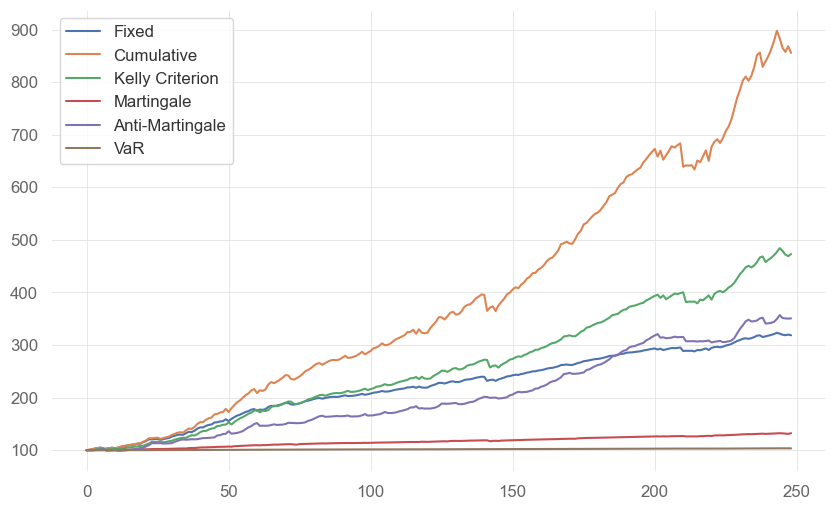

In [270]:
equities = pd.concat([fixed_size_equity,
                      cum_size_equity,
                      kelly_equity,
                      martingale_equity,
                      antimartingale_equity,
                      var_equity], axis=1).shift().fillna(100)

equities.columns = ['Fixed', 'Cumulative', 'Kelly Criterion', 'Martingale', 'Anti-Martingale', 'VaR']
equities.plot()

### and performance metrics

In [276]:
stats = pd.concat([
    
    equities.pct_change().fillna(0).apply(ep.sharpe_ratio).round(2),
    equities.pct_change().fillna(0).apply(ep.max_drawdown).mul(100).round(2)], axis=1)

stats.columns = ['sharpe', 'maxdd (%)']
stats

sharpe  maxdd (%)
Fixed              9.01      -3.33
Cumulative         9.06      -8.00
Kelly Criterion    8.96      -5.53
Martingale         7.76      -1.55
Anti-Martingale    7.87      -4.97
VaR                9.20      -0.14